# AIOps anomaly detection

#### Todo: enrich introduction.

For demonstration, we use the publicly available cluster trace data `cluster-trace-v2018` of Alibaba Open Cluster Trace Program. You can find the dataset introduction [here](https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md). In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with [machine_usage](http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz).

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

Note that these helper functions are just a copy of notebook "../network_traffic/network_traffic_model_forecasting.ipynb". And we need to make some changes to apply to AIOps dataset.

#### TODO
1. fix bugs in get_drop_ts_and_len and modify rm_missing_weeks. You can change function names or do more refactoring as you like. We simply remove the first two days directly for machine 1932. But things may be different for other machines so we still need to support remove days. 
2. remove useless helper function and add more.

In [1]:
# bug in this function, need to correct start index
def get_drop_ts_and_len(df, target_col="cpu_usage", allow_missing_num=3):
    """
    get start index which with consecutive missing num larger than allow_missing_num
    """
    missing_num = df[target_col].isnull().astype(int).groupby(df[target_col].notnull().astype(int).cumsum()).sum()
    drop_missing_num = missing_num[missing_num > allow_missing_num]
    drop_ts = df.iloc[drop_missing_num.index].index
    drop_len = drop_missing_num.values
    return drop_ts, drop_len

In [2]:
# need to remove missing days in this example. Or you can make it more general and support both weeks and days.
def rm_missing_weeks(start_dts, missing_lens, df):
    """
    Drop weeks that contains more than 3 consecutive missing values.
    If consecutive missing values across weeks, we remove all the weeks.
    """ 
    for start_time, l in zip(start_dts, missing_lens):
        start = start_time - pd.Timedelta(days=start_time.dayofweek)
        start = start.replace(hour=0, minute=0, second=0)
        start_week_end = start + pd.Timedelta(days=6)
        start_week_end = start_week_end.replace(hour=22, minute=0, second=0)

        end_time = start_time + l*pd.Timedelta(hours=2)
        if start_week_end < end_time:
            end = end_time + pd.Timedelta(days=6-end_time.dayofweek)
            end = end.replace(hour=22, minute=0, second=0)
        else:
            end = start_week_end
        df = df.drop(df[start:end].index)
    return df

In [4]:
def roll_data(dataset, look_back, target_col_index):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i: (i + look_back)])
        Y.append(dataset[i + look_back, [target_col_index]])
    return np.array(X), np.array(Y)

In [5]:
def unscale(scaler, y, target_col_indexes):
    """
    data needs to be normalized (scaled) before feeding into models. 
    This is to inverse the effect of normlization to get reasonable forecast results.
    """
    dummy_feature_shape = scaler.scale_.shape[0]
    y_dummy = np.zeros((y.shape[0], dummy_feature_shape))
    y_dummy[:, target_col_indexes] = y
    y_unscale = scaler.inverse_transform(y_dummy)[:,target_col_indexes]
    return y_unscale

In [6]:
EPSILON = 1e-10
def sMAPE(y_true, y_pred):
    """
    Symmetric Mean Average Percentage Error
    """
    output_errors = np.mean(100 * np.abs(y_true - y_pred)/(np.abs(y_true) + np.abs(y_pred) + EPSILON), axis=0,)
    return np.mean(output_errors)

## Download raw dataset and load into dataframe

We use machine 1932 as an example. You can choose any machines in the similar way. You can run `grep m_1932 machine_usage.csv > m_1932.csv` to extract records of machine 1932.

#### TODO: add some explanation docs

In [8]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
df_1932 = pd.read_csv("m_1932.csv", header=None, usecols=[1,2,3], names=["time_step", "cpu_usage","mem_usage"])

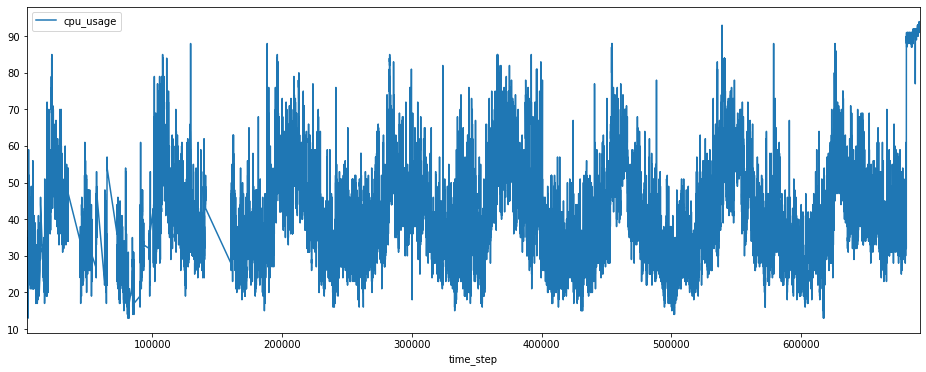

In [10]:
df_1932.sort_values(by="time_step").plot(y="cpu_usage", x="time_step", figsize=(16,6))

In [11]:
df_1932["ts_min"] = df_1932["time_step"]//60

In [12]:
resampled_df = df_1932.groupby("ts_min").agg({"cpu_usage":"mean"})

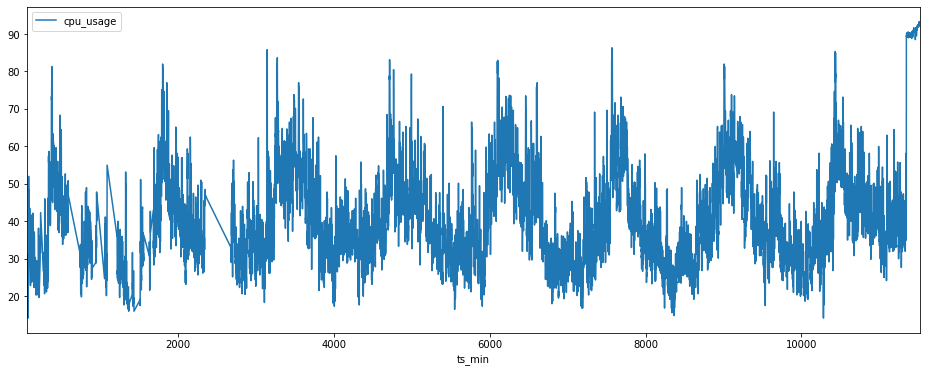

In [13]:
resampled_df.plot(figsize=(16,6))

As we can see, the first two days contains some consecutive missing values, so we start from the third day.

In [14]:
df = resampled_df[1440*2:].reset_index(drop=True)

In [15]:
# check missing values, we don't need to fill missing values since there isn't any.
df.isna().sum()

cpu_usage    0
dtype: int64

we need datetime information to generate related features

In [16]:
df.index=pd.to_datetime(df.index, unit='m', origin=pd.Timestamp('2018-01-01'))

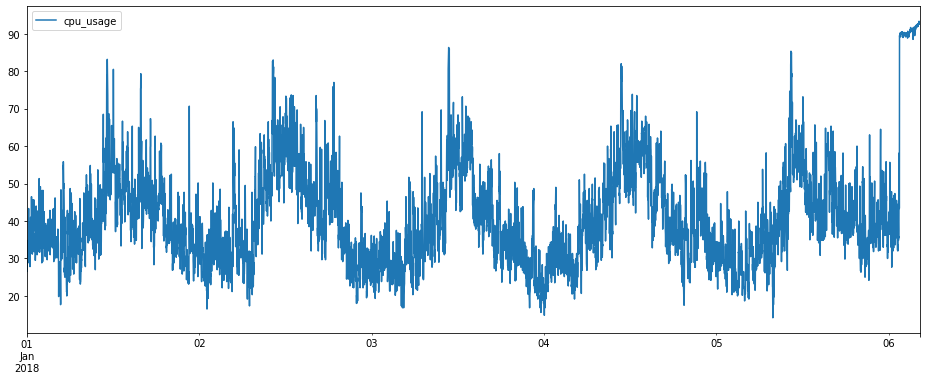

In [18]:
df.plot(figsize=(16,6))

## Feature Engineering

In [19]:
df["hour"] = df.index.hour

In [20]:
df.head()

,cpu_usage,hour
2018-01-01 00:00:00,28.333333,0
2018-01-01 00:01:00,26.500000,0
2018-01-01 00:02:00,28.000000,0
2018-01-01 00:03:00,33.833333,0
2018-01-01 00:04:00,30.833333,0


## Data preparation

Now we split the dataset into train, validation and test.

In [23]:
val_ratio = 0.1
test_ratio = 0.1
# we look back one hour data which is of the frequency of 1min.
look_back = 60
horizon = 1

def train_val_test_split(df, val_ratio, test_ratio, look_back, horizon):
    total_num = df.index.size
    test_num = int(total_num * test_ratio)
    val_num = int(total_num * val_ratio)
    
    test_split_index = test_num + look_back + horizon - 1
    val_split_index = test_split_index + val_num 
    
    train_df = df.iloc[:-(test_num + val_num)]  
    val_df = df.iloc[-val_split_index: -test_num]
    test_df = df.iloc[-test_split_index: ]
    
    return train_df, val_df, test_df
train_df, val_df, test_df = train_val_test_split(df, val_ratio, test_ratio, look_back, horizon)

In [24]:
train_df.index.size, val_df.index.size, test_df.index.size

(5969, 805, 805)

Then standardize train, test data and featues

In [25]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_df)
scaled_val = standard_scaler.transform(val_df)
scaled_test = standard_scaler.transform(test_df)

Last, we generate model input samples by sliding window along time axis. Since univariant and multivariant forcasting uses different input data shape, we prepare data for each type of forcasting respectively.


In [26]:
val_df.head()

,cpu_usage,hour
2018-01-05 02:29:00,26.166667,2
2018-01-05 02:30:00,26.666667,2
2018-01-05 02:31:00,22.333333,2
2018-01-05 02:32:00,25.000000,2
2018-01-05 02:33:00,26.666667,2


In [27]:
import numpy as np
x_train, y_train = roll_data(scaled_train, look_back, target_col_index=0)
x_val, y_val = roll_data(scaled_val, look_back, target_col_index=0)
x_test, y_test = roll_data(scaled_test, look_back, target_col_index=0)

In [28]:
x_test.shape, y_test.shape

((745, 60, 2), (745, 1))

# Time series forecasting 

In [29]:
from zoo.zouwu.model.forecast import MTNetForecaster

W0508 11:10:23.259577 140072580880128 module_wrapper.py:139] From /home/shan/sources/automl-analytics-zoo/pyzoo/zoo/tfpark/zoo_optimizer.py:27: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



First, we initialize a mtnet_forecaster according to input data shape. Specifcally, `look_back` should equal `(lb_long_steps+1)*lb_long_stepsize` .Details refer to [zouwu docs](https://github.com/intel-analytics/analytics-zoo/tree/master/pyzoo/zoo/zouwu).

#### TODO: You can try finetuning MTNet to get better results and be familiar with MTNetForecaster

In [30]:
# need to change `horizon` to `target_dim` if PR #2265 is merged 
mtnet_forecaster = MTNetForecaster(horizon=horizon,
                                   feature_dim=x_train.shape[-1],
                                   lb_long_steps=3,
                                   lb_long_stepsize=15
    )

W0508 11:10:24.105106 140072580880128 deprecation.py:506] From /home/shan/anaconda2/envs/ray36/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:94: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0508 11:10:24.114427 140072580880128 deprecation.py:506] From /home/shan/anaconda2/envs/ray36/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0508 11:10:24.170781 140072580880128 backend.py:548] OMP_NUM_THREADS is no longer used by the default Keras config. To configure the number of threads

MTNet needs to preprocess the X into another format, so we call `MTNetForecaster.preprocess_input` on train_x and test_x.

In [31]:
# mtnet requires reshape of input x before feeding into model.
x_train_mtnet = mtnet_forecaster.preprocess_input(x_train)
x_val_mtnet = mtnet_forecaster.preprocess_input(x_val)
x_test_mtnet = mtnet_forecaster.preprocess_input(x_test)

Now we train the model and wait till it finished. 

In [32]:
%%time
hist = mtnet_forecaster.fit(x = x_train_mtnet, y = y_train, batch_size=128, epochs=20)

W0508 11:10:34.847883 140072580880128 deprecation.py:323] From /home/shan/anaconda2/envs/ray36/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5909 samples
Epoch 1/20
5909/5909 [==============================] - 12s 2ms/sample - loss: 0.8129 - mean_squared_error: 1.0828
Epoch 2/20
5909/5909 [==============================] - 7s 1ms/sample - loss: 0.5806 - mean_squared_error: 0.6351
Epoch 3/20
5909/5909 [==============================] - 8s 1ms/sample - loss: 0.4491 - mean_squared_error: 0.3643
Epoch 4/20
5909/5909 [==============================] - 7s 1ms/sample - loss: 0.3995 - mean_squared_error: 0.2946
Epoch 5/20
5909/5909 [==============================] - 7s 1ms/sample - loss: 0.3760 - mean_squared_error: 0.2601
Epoch 6/20
5909/5909 [==============================] - 7s 1ms/sample - loss: 0.3571 - mean_squared_error: 0.2396
Epoch 7/20
5909/5909 [==============================] - 7s 1ms/sample - loss: 0.3494 - mean_squared_error: 0.2293
Epoch 8/20
5909/5909 [==============================] - 7s 1ms/sample - loss: 0.3429 - mean_squared_error: 0.2198
Epoch 9/20
5909/5909 [==============================] - 7s 1ms/sa

Use the model for prediction and inverse the scaling of the prediction results

In [33]:
y_pred_val = mtnet_forecaster.predict(x_val_mtnet)
y_pred_test = mtnet_forecaster.predict(x_test_mtnet)

In [34]:
y_pred_val_unscale = unscale(standard_scaler, y_pred_val, [0])
y_pred_test_unscale = unscale(standard_scaler, y_pred_test, [0])

In [35]:
# evaluate with sMAPE
print("sMAPE is",sMAPE(y_pred_test_unscale, y_test_unscale))

sMAPE is 6.267992988119415


#### TODO: change to anomaly detector interface in `zoo.zouwu.model.anomaly`

In [72]:
def get_result_df(df, y_pred_unscale, look_back):
    result_df = pd.DataFrame({"y_true":df[look_back:]["cpu_usage"], "y_pred": y_pred_unscale.squeeze()})
    result_df["diff"] = abs(result_df.y_true - result_df.y_pred)
    return result_df 

val_result_df = get_result_df(val_df, y_pred_val_unscale, look_back)
test_result_df = get_result_df(test_df, y_pred_test_unscale, look_back)

In [73]:
def get_threshold(val_result_df, outliers_fraction = 0.01):
    number_of_outliers = int(outliers_fraction*len(val_diff))
    threshold = val_result_df["diff"].nlargest(number_of_outliers).min()
    return threshold

threshold = get_threshold(val_result_df)

In [74]:
val_result_df["anomalies"] = val_result_df["diff"] > threshold
test_result_df["anomalies"] = test_result_df["diff"] > threshold

#### TODO: refactor to plot function. Fix labels.

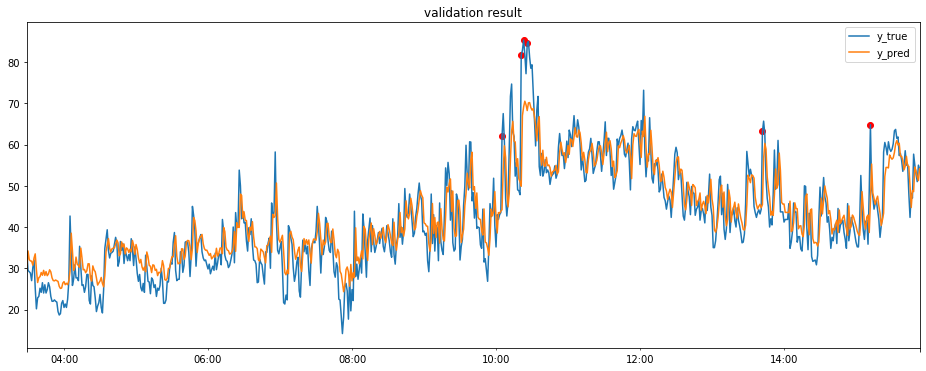

In [99]:
ax = val_result_df.plot(y=["y_true", "y_pred"], figsize=[16, 6], title="validation result")
anomalies = val_result_df[val_result_df.anomalies]
ax.scatter(anomalies.index.tolist(), anomalies.y_true, color='red', label='anomalies value')

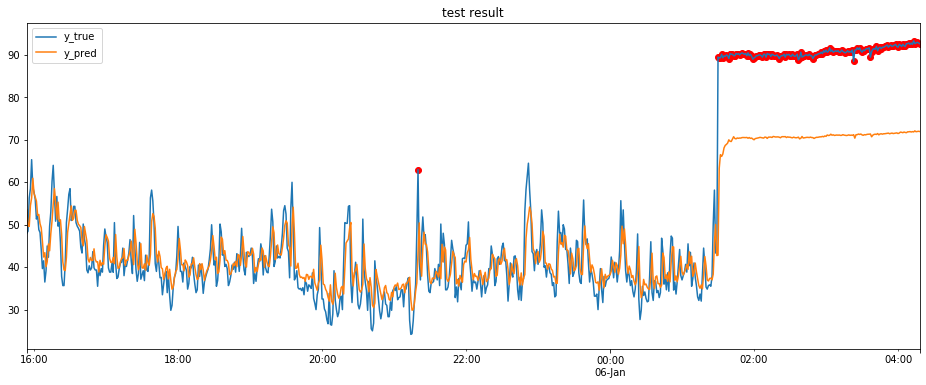

In [100]:
ax = test_result_df.plot(y=["y_true", "y_pred"], figsize=[16, 6], title="test result")
anomalies = test_result_df[test_result_df.anomalies]
ax.scatter(anomalies.index.tolist(), anomalies.y_true, color='red', label='anomalies value')